<a href="https://colab.research.google.com/github/winstonlarson/-folio/blob/master/Cluster_InfoGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cluster InfoGAN MNIST

https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py

Import libraries

In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from tensorflow.keras.layers import LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
import numpy as np
import os

In [0]:
IMG_ROWS = 28
IMG_COLS = 28
CHANNELS = 1
NUM_CLASSES = 10
IMG_SHAPE = (IMG_ROWS, IMG_COLS, CHANNELS)
LATENT_DIM = 72

In [0]:
def save_images(epoch, generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, LATENT_DIM))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [0]:
def build_generator():

    # model = Sequential()
    gen_input = Input(shape=(LATENT_DIM,))
    gen = Dense(128 * 7 * 7, activation="relu", input_dim=LATENT_DIM)(gen_input)
    gen = Reshape((7, 7, 128))(gen)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = UpSampling2D()(gen)
    gen = Conv2D(128, kernel_size=3, padding="same")(gen)
    gen = Activation("relu")(gen)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = UpSampling2D()(gen)
    gen = Conv2D(64, kernel_size=3, padding="same")(gen)
    gen = Activation("relu")(gen)
    gen = BatchNormalization(momentum=0.8)(gen)
    gen = Conv2D(CHANNELS, kernel_size=3, padding='same')(gen)
    gen_output = Activation("tanh")(gen)

    return Model(gen_input, gen_output)

In [0]:
def build_disk_and_q_net():

    img = Input(shape=IMG_SHAPE)

    # Shared layers between discriminator and recognition network
    # model = Sequential()
    shared = Conv2D(64, kernel_size=3, strides=2, input_shape=IMG_SHAPE, padding="same")(img)
    shared = LeakyReLU(alpha=0.2)(shared)
    shared = Dropout(0.25)(shared)
    shared = Conv2D(128, kernel_size=3, strides=2, padding="same")(shared)
    shared = ZeroPadding2D(padding=((0,1),(0,1)))(shared)
    shared = LeakyReLU(alpha=0.2)(shared)
    shared = Dropout(0.25)(shared)
    shared = BatchNormalization(momentum=0.8)(shared)
    shared = Conv2D(256, kernel_size=3, strides=2, padding="same")(shared)
    shared = LeakyReLU(alpha=0.2)(shared)
    shared = Dropout(0.25)(shared)
    shared = BatchNormalization(momentum=0.8)(shared)
    shared = Conv2D(512, kernel_size=3, strides=2, padding="same")(shared)
    shared = LeakyReLU(alpha=0.2)(shared)
    shared = Dropout(0.25)(shared)
    shared = BatchNormalization(momentum=0.8)(shared)
    img_embedding = Flatten()(shared)

    # img_embedding = model(img)

    # Discriminator 
    validity = Dense(1, activation='sigmoid')(img_embedding)

    # Recognition
    q_net = Dense(128, activation='relu')(img_embedding)
    label = Dense(NUM_CLASSES, activation='softmax')(q_net)

    # Return discriminator and recognition network
    return Model(img, validity), Model(img, label)

In [0]:
def mutual_info_loss(c, c_given_x):
    """The mutual information metric we aim to minimize"""
    eps = 1e-8
    conditional_entropy = K.mean(- K.sum(K.log(c_given_x + eps) * c, axis=1))
    entropy = K.mean(- K.sum(K.log(c + eps) * c, axis=1))

    return conditional_entropy + entropy

In [0]:
def sample_generator_input(BATCH_SIZE):
    # Generator inputs
    sampled_noise = np.random.normal(0, 1, (BATCH_SIZE, 62))
    sampled_labels = np.random.randint(0, NUM_CLASSES, BATCH_SIZE).reshape(-1, 1)
    sampled_labels = to_categorical(sampled_labels, num_classes=NUM_CLASSES)

    return sampled_noise, sampled_labels

In [0]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Rescale -1 to 1
train_images = (train_images.astype(np.float32) - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=3)
train_labels = train_labels.reshape(-1, 1)

test_images = (test_images.astype(np.float32) - 127.5) / 127.5
test_images = np.expand_dims(test_images, axis=3)

In [0]:
optimizer = Adam(0.0002, 0.5)
losses = ['binary_crossentropy', mutual_info_loss]

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
discriminator, auxilliary = build_disk_and_q_net()

discriminator.compile(loss=['binary_crossentropy'],
                      optimizer=optimizer,
                      metrics=['accuracy'])

auxilliary.compile(loss=[mutual_info_loss],
                        optimizer=optimizer,
                        metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
generator = build_generator()

generator_input = Input(shape=(LATENT_DIM,))
image = generator(generator_input)

discriminator.trainable = False

validity = discriminator(image)
target_label = auxilliary(image)

combined = Model(generator_input, [validity, target_label])
combined.compile(loss=losses, optimizer=optimizer)

In [0]:
EPOCHS = 5001
BATCH_SIZE = 128
SAMPLE_INTERVAL = 500

In [0]:
if not os.path.exists('images/'):
  os.makedirs('images/')
if not os.path.exists('models/'):
  os.makedirs('models/')

In [0]:
def train():

    # Adversarial ground truths
    expected_valid = np.ones((BATCH_SIZE, 1))
    expected_fake = np.zeros((BATCH_SIZE, 1))

    for epoch in range(EPOCHS):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        batch = np.random.randint(0, train_images.shape[0], BATCH_SIZE)
        images = train_images[batch]

        # Sample noise and categorical labels
        sampled_noise, sampled_labels = sample_generator_input(BATCH_SIZE)
        gen_input = np.concatenate((sampled_noise, sampled_labels), axis=1)

        # Generate a half batch of new images
        gen_imgs = generator.predict(gen_input)

        # Train on real and generated data
        d_loss_real = discriminator.train_on_batch(images, expected_valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, expected_fake)

        # Avg. loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator and Q-network
        # ---------------------

        g_loss = combined.train_on_batch(gen_input, [expected_valid, sampled_labels])

        # If at save interval => save generated image samples
        if epoch % SAMPLE_INTERVAL == 0:
            save_images(epoch, generator)
            print ("%d [D loss: %.2f, acc.: %.2f%%] [Q loss: %.2f] [G loss: %.2f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[1], g_loss[2]))
            generator.save("models/gen_%d.hd5" % epoch)
            discriminator.save("models/disc_%d.hd5" % epoch)

In [0]:
train()

Instructions for updating:
Use tf.cast instead.
0 [D loss: 1.09, acc.: 46.88%] [Q loss: 1.03] [G loss: 2.95]
500 [D loss: 0.78, acc.: 55.08%] [Q loss: 0.82] [G loss: 0.04]
1000 [D loss: 0.73, acc.: 53.52%] [Q loss: 0.75] [G loss: 0.01]
1500 [D loss: 0.73, acc.: 55.47%] [Q loss: 0.72] [G loss: 0.01]
2000 [D loss: 0.74, acc.: 50.78%] [Q loss: 0.69] [G loss: 0.01]
2500 [D loss: 0.70, acc.: 56.25%] [Q loss: 0.70] [G loss: 0.00]
3000 [D loss: 0.72, acc.: 53.52%] [Q loss: 0.64] [G loss: 0.00]
3500 [D loss: 0.71, acc.: 52.34%] [Q loss: 0.65] [G loss: 0.00]
4000 [D loss: 0.70, acc.: 51.56%] [Q loss: 0.63] [G loss: 0.00]
4500 [D loss: 0.70, acc.: 51.17%] [Q loss: 0.67] [G loss: 0.00]
5000 [D loss: 0.69, acc.: 53.52%] [Q loss: 0.66] [G loss: 0.00]


In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('images/mnist_5000.png')

In [0]:
new_disc = load_model('models/disc_5000.hd5')

In [0]:
chopped_disc = Model(new_disc.inputs, new_disc.layers[-2].output)
chopped_disc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 128)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
__________

In [0]:
chopped_flat_output = chopped_disc.predict(test_images)
print(chopped_flat_output.shape)
chopped_flat_output

(10000, 2048)


array([[-1.3473245 , -0.58576894, -1.7137791 , ..., -0.4480313 ,
        -0.27930167, -0.6217854 ],
       [-0.36521852, -0.20674282, -0.745016  , ..., -0.1803604 ,
        -0.16319025, -0.5758529 ],
       [-1.4072446 , -1.2072629 , -1.4718748 , ..., -0.4383658 ,
        -0.2826519 , -0.6202229 ],
       ...,
       [-0.7438277 , -0.4720553 , -0.6513249 , ..., -0.4361339 ,
        -0.28718066, -0.62022877],
       [ 0.10326747, -0.8354136 , -1.0677477 , ..., -0.46666768,
        -0.27658045, -0.6233153 ],
       [ 0.55118006, -0.540073  , -1.4577026 , ..., -0.5824532 ,
        -0.19818647, -0.5961566 ]], dtype=float32)

In [0]:
from scipy.spatial.distance import pdist, squareform

dist = pdist(chopped_flat_output)
distances = squareform(dist)
distances

array([[ 0.        , 39.8778614 , 31.86064396, ..., 25.55253029,
        27.88301159, 48.55777579],
       [39.8778614 ,  0.        , 44.28314178, ..., 34.79136595,
        30.85553396, 33.66348158],
       [31.86064396, 44.28314178,  0.        , ..., 38.41487703,
        31.57251447, 55.51135889],
       ...,
       [25.55253029, 34.79136595, 38.41487703, ...,  0.        ,
        20.38631021, 37.27837716],
       [27.88301159, 30.85553396, 31.57251447, ..., 20.38631021,
         0.        , 39.59646565],
       [48.55777579, 33.66348158, 55.51135889, ..., 37.27837716,
        39.59646565,  0.        ]])

In [0]:
classes = range(10)
for i in classes:
  print(i, test_labels[distances[test_labels==i][10].argsort()[:20]])

0 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
3 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
4 [4 4 4 9 4 4 4 9 4 9 9 4 9 9 4 9 9 9 9 4]
5 [5 5 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5]
6 [6 6 6 6 6 6 6 2 6 2 6 6 6 6 6 4 6 2 6 6]
7 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
8 [8 8 8 8 8 8 8 8 8 8 8 8 8 3 8 8 8 8 8 8]
9 [9 9 7 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9]


In [0]:
means = np.zeros((10,10))
for i in classes:
  for j in classes:
    means[i, j] = distances[test_labels==i][:,test_labels==j].mean()

print(np.triu(np.round(means, 2)))

[[35.6  53.3  41.29 42.37 46.71 43.94 44.23 45.07 40.95 45.93]
 [ 0.   19.52 41.24 42.86 34.5  39.83 39.86 32.39 38.93 34.09]
 [ 0.    0.   32.93 37.41 36.41 38.02 34.29 37.46 34.42 36.21]
 [ 0.    0.    0.   33.69 39.32 35.89 38.93 36.48 34.42 37.02]
 [ 0.    0.    0.    0.   27.22 37.71 32.01 32.76 34.68 28.62]
 [ 0.    0.    0.    0.    0.   34.61 38.83 36.78 34.24 36.71]
 [ 0.    0.    0.    0.    0.    0.   26.9  36.83 35.68 33.14]
 [ 0.    0.    0.    0.    0.    0.    0.   26.91 33.82 30.12]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   29.92 33.25]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   27.34]]


In [0]:
near_counts_3 = np.zeros((np.unique(test_labels).size, np.unique(test_labels).size))
class_counts_3 = np.zeros(np.unique(test_labels).size)

for i in np.unique(test_labels):
  print('new i', i)
  for j in range(np.sum(test_labels==i)):
    for near_member in test_labels[distances[test_labels==i][j].argsort()[:3]]:
      near_counts_3[i,near_member] += 1
      class_counts_3[i] += 1

near_frac_3 = np.copy(near_counts_3)
for i in range(class_counts_3.size):
  near_frac_3[i,:] = near_frac_3[i,:]/class_counts_3[i]

for i in range(near_frac_3.shape[0]):
  print(i, near_frac_3[i,:])

near_counts_5 = np.zeros((np.unique(test_labels).size, np.unique(test_labels).size))
class_counts_5 = np.zeros(np.unique(test_labels).size)

for i in np.unique(test_labels):
  print('new i', i)
  for j in range(np.sum(test_labels==i)):
    for near_member in test_labels[distances[test_labels==i][j].argsort()[:5]]:
      near_counts_5[i,near_member] += 1
      class_counts_5[i] += 1

near_frac_5 = np.copy(near_counts_5)
for i in range(class_counts_5.size):
  near_frac_5[i,:] = near_frac_5[i,:]/class_counts_5[i]

for i in range(near_frac_5.shape[0]):
  print(i, near_frac_5[i,:])

near_counts_10 = np.zeros((np.unique(test_labels).size, np.unique(test_labels).size))
class_counts_10 = np.zeros(np.unique(test_labels).size)

for i in np.unique(test_labels):
  print('new i', i)
  for j in range(np.sum(test_labels==i)):
    for near_member in test_labels[distances[test_labels==i][j].argsort()[:10]]:
      near_counts_10[i,near_member] += 1
      class_counts_10[i] += 1

near_frac_10 = np.copy(near_counts_10)
for i in range(class_counts_10.size):
  near_frac_10[i,:] = near_frac_10[i,:]/class_counts_10[i]

for i in range(near_frac_10.shape[0]):
  print(i, near_frac_10[i,:])

new i 0
new i 1
new i 2
new i 3
new i 4
new i 5
new i 6
new i 7
new i 8
new i 9
0 [9.74829932e-01 0.00000000e+00 1.70068027e-03 2.38095238e-03
 6.80272109e-04 2.72108844e-03 7.82312925e-03 1.70068027e-03
 7.48299320e-03 6.80272109e-04]
1 [0.00000000e+00 9.90308370e-01 3.52422907e-03 8.81057269e-04
 2.93685756e-04 0.00000000e+00 1.76211454e-03 1.17474302e-03
 1.46842878e-03 5.87371512e-04]
2 [0.01776486 0.00258398 0.92700258 0.0122739  0.00549096 0.00193798
 0.01356589 0.00742894 0.00968992 0.00226098]
3 [0.00990099 0.00231023 0.00891089 0.86138614 0.00165017 0.05049505
 0.00528053 0.00528053 0.04356436 0.01122112]
4 [1.01832994e-03 1.01832994e-03 2.71554650e-03 3.39443313e-04
 9.04955872e-01 1.01832994e-03 1.05227427e-02 3.73387644e-03
 3.39443313e-04 7.43380855e-02]
5 [3.36322870e-03 7.47384155e-04 1.86846039e-03 7.13751868e-02
 1.86846039e-03 8.53512706e-01 1.86846039e-02 1.12107623e-03
 3.69955157e-02 1.04633782e-02]
6 [6.26304802e-03 2.78357690e-03 5.21920668e-03 3.47947112e-04
 3.

In [0]:
import seaborn as sns; sns.set()

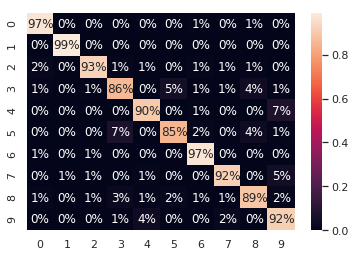

In [0]:
sns.heatmap(near_frac_3, annot=True, fmt='.0%')

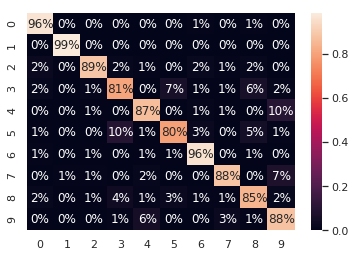

In [0]:
sns.heatmap(near_frac_5, annot=True, fmt='.0%')

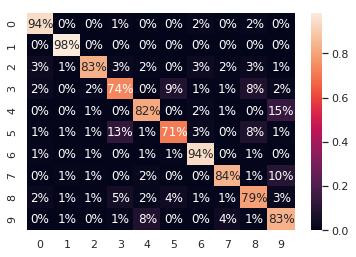

In [0]:
sns.heatmap(near_frac_10, annot=True, fmt='.0%')